### ETAS: NorCal, General Purpose


In [1]:
#
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import datetime as dtm
import matplotlib.dates as mpd
import pytz
tzutc = pytz.timezone('UTC')

#import operator
import math
import random
import numpy
import scipy
import scipy.optimize as spo
from scipy import interpolate
import itertools
import sys
#import scipy.optimize as spo
import os
import operator
#from PIL import Image as ipp
import multiprocessing as mpp
#
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import json
import pickle
#

import geopy.distance
#from geopy.distance import vincenty
#from geopy.distance import great_circle
#
#import shapely.geometry as sgp
#
from mpl_toolkits.basemap import Basemap as Basemap
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from geographiclib.geodesic import Geodesic as ggp
#

#import ANSStools as atp
from yodiipy import ANSStools as atp
#

import contours2kml
import globalETAS as gep

import global_etas_auto as ggep

from eq_params import *
#
from nepal_figs import *
import optimizers
#
import random
import geopy

local_path: 
failed while loading urllib and/or urllib. maybe python 3.x?


/home/myoder/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
# event was some time on the 24th or maybe late the 23rd. this, plus defaults, should find the event:
#to_dt = dtm.datetime(2016,8,25, tzinfo=pytz.timezone('UTC'))
to_dt = dtm.datetime.now(pytz.timezone('UTC'))
#
Lr_factor = 10.
# define these from the t_now in the actual etas object, in the event that we load it from pickle,
#  rather than calc it here.
#f_path = '/home/myoder/Dropbox/Research/etas/italy_2016_10/etas_{}'.format(to_dt)
#f_root = 'etas_2016'
#

t0 = dtm.datetime.now(pytz.timezone('UTC'))
t_ms = t0
to_dt
#
# sacramento:
lat0 = 38.5816
lon0 = -121.4944
ll_sacramento = (lon0, lat0)

#m0 = 7.8

d_lat=5.
d_lon=5.
#
lats = [lat0-d_lat, lat0+d_lat]
lons = [lon0-d_lon, lon0+d_lon]
#to_dt = t0-dtm.timedelta(hours=2)
#to_dt = dtm.datetime.now(pytz.utc)
#
#etas = ggep.auto_etas(to_dt=to_dt, Lr_factor=Lr_factor, dt_0=5)
#italy_prams = {'do_recarray': True, 'D_fract': 1.5,
#                't_0':dtm.datetime(1990, 1, 1, 0, 0, tzinfo=pytz.timezone('UTC')),
#                't_now':to_dt, 
#                'lats': [42.,43.5], 'p': 1.1, 'b1': 1.0, 'mc': 2.5, 'q': 1.5,
#                'lons': [12.,15.], 'dmstar': 1.0, 'b2': 1.5, 'd_tau': 2.28,
#                'incat': None, 'fit_factor': 2.0, 'd_lambda': 1.76}
eq_prams = {'do_recarray': True, 'D_fract': 1.5,
               't_0':dtm.datetime(1990, 1, 1, 0, 0, tzinfo=pytz.timezone('UTC')),
               't_now':to_dt, 
               'lats': lats, 'p': 1.1, 'b1': 1.0, 'mc': 1., 'q': 1.5,
               'lons': lons, 'dmstar': 1.0, 'b2': 1.5, 'd_tau': 2.28,
               'incat': None, 'fit_factor': 2.0, 'd_lambda': 1.76, 'etas_range_padding':1.5,
            'etas_range_factor':30.0, 'ab_ratio_expon':.25 }
eq_prams.update({'mc':3.0, 'd_lat':.25, 'd_lon':.25})

In [4]:
# let's add a preliminary map...
class Preliminary_Map(object):
    def __init__(self, lats, lons):
        pass

In [5]:
n_cpu = 2*mpp.cpu_count()
#n_cpu=5
etas = gep.ETAS_mpp(n_cpu=n_cpu, **eq_prams)
#
# we've run this; we can reload it from pickle:
#with open('data/etas_201610.pkl', 'rb') as fin:
#    etas = pickle.load(fin)
#
event_name = 'NorCal_general'
f_path = '/home/myoder/Dropbox/Research/etas/{}/etas_{}'.format(event_name, etas.t_now)
f_root = 'etas_{}_2016_11'.format(event_name)

begin globalETAS.__init()__
Overriding t_0 (etas catalog start date/time) for ETAS calculations. using catalog start, t_0 = t_now - catlen (1825.000000) = 2012-03-04 06:04:27.743565+00:00
fetch and process catalog for dates: [datetime.datetime(2012, 3, 4, 6, 4, 27, 743565, tzinfo=<UTC>), datetime.datetime(2017, 3, 3, 6, 4, 27, 743565, tzinfo=<UTC>)]
etas_prams:  {'d_lambda': 1.76, 'p': 1.1, 'lons': [-126.4944, -116.4944], 'date_range': [datetime.datetime(2012, 3, 4, 6, 4, 27, 743565, tzinfo=<UTC>), datetime.datetime(2017, 3, 3, 6, 4, 27, 743565, tzinfo=<UTC>)], 'b1': 1.0, 'lats': [33.5816, 43.5816], 'incat': None, 'fit_factor': 1.0, 'q': 1.5, 'do_recarray': False, 'D_fract': 1.5, 'b2': 1.5, 'mc': 3.0, 'dmstar': 1.0, 'd_tau': 2.28}
data handle fetched...
 no file.
results fetched.
catalog fetched and processed.
ETAS over etas_cat_range/xyz_range:  ([0, 1319], None)
make_etas():
etas_mpp worker xyz_range:  [0, 100]
begin globalETAS.__init()__
Overriding t_0 (etas catalog start date/time)

In [6]:
#print(etas.t0, etas.t_now, etas.t_forecast, etas.catalog[-1])

ms:  (datetime.datetime(2016, 12, 8, 14, 49, 45, 910000), 40.4535, -126.1936, 6.6, 8.45, 736306.6178924768, 34.67368504525315, 192.65283727453274, 0.00036194475781204527, 10.471285480508996, 20.07270154703196, 0.018609701936058196, 1.0, 1.1, 1.5, array([ 3.6886866 ,  9.98001195]), array([[-0.75615405,  0.65439366],
       [-0.65439366, -0.75615405]]), 25.0) -126.1936 40.4535
tt:  736376.2530988839 2012-03-05T05:33:12.590000-0800 <class 'numpy.datetime64'>


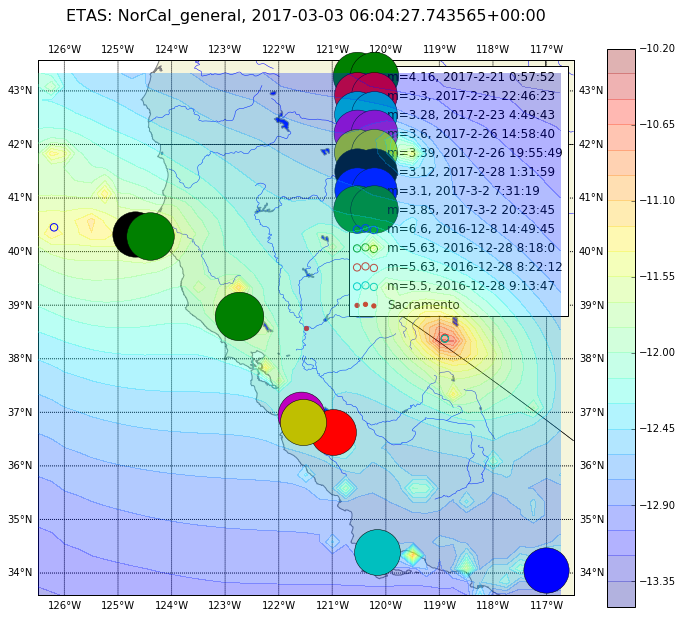

In [7]:
fg=plt.figure(0, figsize=(12,10))
ax=plt.gca()
etas.make_etas_contour_map(n_contours=25, fignum=0, map_resolution='f', alpha=.3, ax=ax)
#
#mainshock = sorted(etas.catalog, key=lambda rw: rw['mag'])[-1]
#print('mainshock: ', mainshock)
# get mainshock. it's an m>6 event in the last week or so... this is subjective.
# if we just look for the biggest event, we get the L'Aquila event, so we'll need to be more creative...
# or just specify it.

mainshock = etas.catalog[-1]
for j,eq in enumerate(reversed(etas.catalog)):
    #print('*** ', pytz.utc.localize(eq['event_date'].astype(dtm.datetime)))
    if pytz.utc.localize(eq['event_date'].astype(dtm.datetime))<etas.t_now-dtm.timedelta(days=180): break
    if eq['mag']>mainshock['mag']:
        mainshock = eq
        #
    #
#
print('ms: ', mainshock, mainshock['lon'], mainshock['lat'])
x,y = etas.cm(mainshock['lon'], mainshock['lat'])
#
#print('mm: ', max(etas.catalog['mag']))
#
# let's get everything m>6 in the last 6 months?
m6s = [rw for rw in etas.catalog if rw['mag'] >= 5.5 
       and pytz.utc.localize(rw['event_date'].astype(dtm.datetime))>to_dt-dtm.timedelta(days=180)]
#
# plot mainshock:
dt = mainshock['event_date'].astype(dtm.datetime)
dt=t0
dt_str = '{}-{}-{} {}:{}:{}'.format(dt.year, dt.month, dt.day, dt.hour, dt.minute, dt.second)
#etas.cm.plot([x], [y], latlon=False, marker='*', color='r', ms=16, zorder=11,
#                   label='m={}, {}'.format(mainshock['mag'], dt_str))
#etas.cm.plot([lon0], [lat0], latlon=False, marker='*', color='r', ms=16, zorder=11,
#                   label='m={}, {}'.format(m0, dt_str))

ax.set_title('ETAS: {}, {}\n\n'.format(event_name, etas.t_now), size=16)
for j,m6 in enumerate(m6s):
    clr = colors_[j%len(colors_)]
    #
    dt = m6['event_date'].astype(dtm.datetime)
    dt_str = '{}-{}-{} {}:{}:{}'.format(dt.year, dt.month, dt.day, dt.hour, dt.minute, dt.second)
    etas.cm.scatter(m6['lon'], m6['lat'], s=3*(m6['mag']+12.), edgecolors=clr, 
                          c='none', marker='o', zorder=11, label='m={}, {}'.format(m6['mag'], dt_str))

x,y = etas.cm(*ll_sacramento)
etas.cm.scatter([x],[y], marker='o', s=18, edgecolors='r', c='r',
                    label='Sacramento')
t_cat = mpd.date2num(etas.t_now-dtm.timedelta(days=15))
print('tt: ', t_cat, etas.catalog['event_date'][0], type(etas.catalog['event_date'][0]))
k=0
for j,rw in enumerate(etas.catalog):
    if mpd.date2num(rw['event_date'].astype(dtm.datetime))<t_cat: continue
    k+=1
    clr = colors_[k%len(colors_)]
    #
    dt = rw['event_date'].astype(dtm.datetime)
    dt_str = '{}-{}-{} {}:{}:{}'.format(dt.year, dt.month, dt.day, dt.hour, dt.minute, dt.second)
    #etas.cm.scatter(rw['lon'],rw['lat'], s=3*(rw['mag']+12.), edgecolors=clr, 
    #                      c='none', marker='o', zorder=11, label='m={}, {}'.format(rw['mag'], dt_str))
    etas.cm.plot(rw['lon'],rw['lat'], ms=3*(rw['mag']+12.), color=clr, 
                          marker='o', zorder=11, label='m={}, {}'.format(rw['mag'], dt_str), latlon=True)
    
    #
plt.gca().legend()
#print(etas.catalog[-10:])

In [8]:
print(['{},{}\n'.format(rw['event_date'], rw['mag'] ) for rw in etas.catalog if rw['mag'] >= 5.5])
len(['{},{}\n'.format(rw['event_date'], rw['mag'] ) for rw in etas.catalog if rw['mag'] >= 5.5
     and rw['event_date'].astype(dtm.datetime)>dtm.datetime(2016,10,20)])



['2013-05-23T20:47:08.180000-0700,5.69\n', '2014-03-09T22:18:13.430000-0700,6.8\n', '2014-08-24T03:20:44.070000-0700,6.02\n', '2015-01-28T13:08:53.710000-0800,5.72\n', '2016-09-02T20:27:58.090000-0700,5.6\n', '2016-12-08T06:49:45.910000-0800,6.6\n', '2016-12-28T00:18:00.610000-0800,5.63\n', '2016-12-28T00:22:12.210000-0800,5.63\n', '2016-12-28T01:13:47.240000-0800,5.5\n']


4

In [9]:
## hey, pickling works with the new ETAS objects (or at least it appears to...):
# with open('data/etas_201610.pkl', 'wb') as fpkl:
#     pickle.dump( etas, fpkl)    
#
#with open('data/etas_201610.pkl', 'rb') as fin:
#    etas2 = pickle.load(fin)
#
#print(etas2.catalog[0:5])
# TODO: we want the datetime part of the filename to come from the etas object itself, for purposes of
# integrity. BUT, we want this script to be a bit more portable, so we should replace all the etas
# references/object name to just 'etas'
#
etas.export_kml(os.path.join(f_path, '{}_{}.kml'.format(f_root, str(etas.t_now).replace(' ', '_'))))
etas.export_xyz(os.path.join(f_path, '{}_{}.xyz'.format(f_root, str(etas.t_now).replace(' ', '_'))))
fg.savefig(os.path.join(f_path, '{}_{}.png'.format(f_root, str(etas.t_now).replace(' ', '_'))))
#
# so this worked, once upon a time, but breaks maybe when the script does not run cleanly all the way through?
#with open (os.path.join(f_path, '{}_{}.pkl'.format(f_root, str(etas.t_now).replace(' ', '_'))), 'wb') as fpkl:
#    pickle.dump(etas, fpkl)


kml bottom, top:  0 22


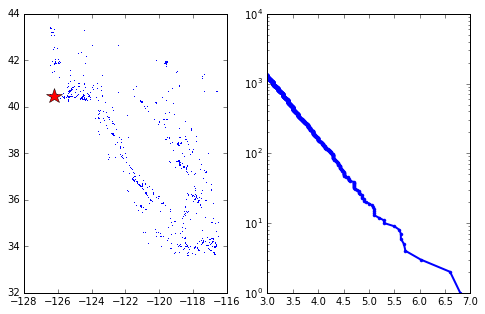

In [10]:
plt.figure(figsize=(8,5))
plt.clf()
ax1=plt.subplot('121')
ax2=plt.subplot('122')
ax1.plot(etas.catalog['lon'], etas.catalog['lat'], ',')
ax1.plot([mainshock['lon']], [mainshock['lat']], marker='*', color='r', ms=16, zorder=11)
#
ax2.plot([m for m in reversed(sorted(etas.catalog['mag']))], numpy.arange(1,len(etas.catalog)+1),
         '.-', lw=2.)
ax2.set_yscale('log')

In [11]:
#print(etas.mc, etas.mc_etas)

In [12]:
# plot a cross-section of ETAS. let's get smart about this and do a PCA on the xyz field...
#
#plt.figure()
##my_xy = [[x,y,z] for x,y in zip(etas.catalog['lon'], etas['lat']) if x>=42.25 and x<=42.75]
#my_xyz = [[x,y,z] for x,y,z in etas.ETAS_array if y>=42.25 and y<=42.75]
#plt.figure(figsize=(8,6))
#plt.plot([x for x,y,z in my_xyz ], [z for x,y,z in my_xyz], '.')

In [13]:
mycat = atp.catfromANSS(lon=lons, lat=lats, minMag=2.5,
                        dates0=[dtm.datetime(2005,1,1, tzinfo=tzutc), None], Nmax=None, fout=None, rec_array=True)


data handle fetched...
 no file.


In [14]:
print(mycat.dtype)

(numpy.record, [('event_date', '<M8[us]'), ('lat', '<f8'), ('lon', '<f8'), ('mag', '<f8'), ('depth', '<f8'), ('event_date_float', '<f8')])
